In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from uav_active_sensing.config import PROCESSED_DATA_DIR
from uav_active_sensing.pytorch_dataloaders import TinyImageNetDataset
from uav_active_sensing.img_exploration_env import ImageExplorationEnv, RewardFunction
from uav_active_sensing.modeling.act_vit_mae import ActViTMAEForPreTraining
from uav_active_sensing.plots import visualize_reconstruction

import torch
from torch.utils.data import DataLoader

from transformers import AutoImageProcessor
from ray.rllib.algorithms.ppo import PPOConfig

2025-02-07 15:38:40.108 | INFO     | uav_active_sensing.config:<module>:11 - PROJ_ROOT path is: /home/tcouso/uav_active_sensing


### Random walk with epoch interface

In [5]:

TINY_IMAGENET_PROCESSED_DIR = PROCESSED_DATA_DIR / "tiny_imagenet/tiny-imagenet-200"
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

def tiny_imagenet_collate_fn(batch):
    processed_batch = [
        image[0]["pixel_values"].to(DEVICE)
        for image in batch
    ]
    
    return torch.cat(processed_batch, dim=0)

image_processor = AutoImageProcessor.from_pretrained("facebook/vit-mae-base", use_fast=True)
tiny_imagenet_train_dataset = TinyImageNetDataset(
    root_dir=TINY_IMAGENET_PROCESSED_DIR, split="train", transform=image_processor
)
tiny_imagenet_val_dataset = TinyImageNetDataset(
    root_dir=TINY_IMAGENET_PROCESSED_DIR, split="val", transform=image_processor
)
dataloader = DataLoader(tiny_imagenet_train_dataset, batch_size=1, collate_fn=tiny_imagenet_collate_fn) # Currently only supports batch size of 1

custom_model = ActViTMAEForPreTraining.from_pretrained("facebook/vit-mae-base")
reward_function = RewardFunction(custom_model)

dummy_image = tiny_imagenet_train_dataset[0]

env_config = {
    "device": DEVICE,
    "dataloader": dataloader,  
    "reward_function": reward_function, 
    # "img_sensor_ratio": None, 
    "patch_size": 16,
    "max_steps": 50,
    "interval_reward_assignment": 10,
    "v_max_x": 10,
    "v_max_y": 10,
    "v_max_z": 2,
}

env = ImageExplorationEnv(env_config)

total_reward = 0

# Random walk loop
for epoch in range(len(env.dataloader)):
    terminated = False
    env.reset() # reset loads a new batch into the environment
    print(f"Epoch: {epoch}")
    while not terminated:
        action = env.action_space.sample()

        next_observation, reward, terminated, truncated, info = env.step(action)
        total_reward += reward.detach().numpy()

        if env.step_count % env.interval_reward_assignment == 0:
            print(f"Reward={total_reward}")
            total_reward = 0

        observation = next_observation


    if epoch == 2:
        break

env.close()

Epoch: 0
Reward=0.5001528263092041
Reward=0.523185133934021
Reward=0.4997399151325226
Reward=0.482517808675766
Reward=0.5068334341049194
Epoch: 1
Reward=0.4414558708667755
Reward=0.4342675507068634
Reward=0.4612181484699249
Reward=0.4484342336654663
Reward=0.45117536187171936
Epoch: 2
Reward=0.41894978284835815
Reward=0.42288583517074585
Reward=0.42137470841407776
Reward=0.39144277572631836
Reward=0.32364943623542786


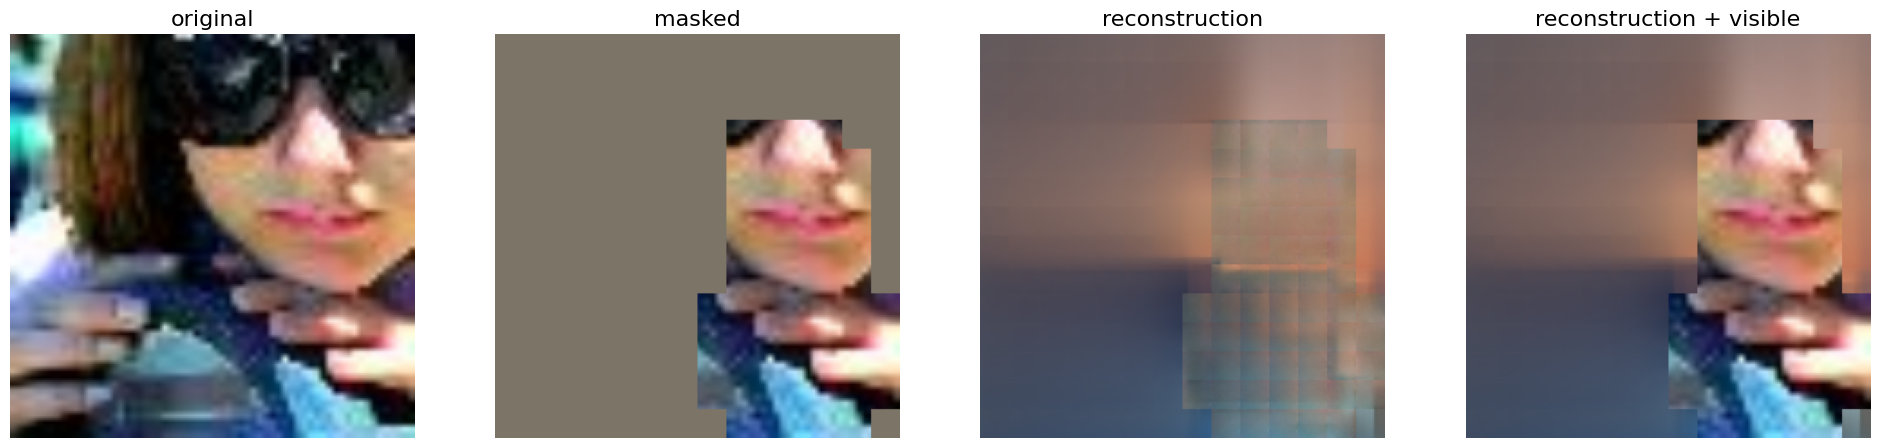

In [6]:
visualize_reconstruction(env.img[0].unsqueeze(0), env.sampled_img[0].unsqueeze(0), custom_model)

### RL agents training

In [7]:
config = (
    PPOConfig()
    .environment(env="ImgExploreEnv-v0", env_config=env_config)  
    .env_runners(num_env_runners=1)  
    .training(
        gamma=0.9, lr=0.01, kl_coeff=0.3, train_batch_size_per_learner=256
    )
)

algo = config.build_algo()
algo.train()

2025-02-07 15:24:33,244	WARNING algorithm_config.py:4726 -- You are running PPO on the new API stack! This is the new default behavior for this algorithm. If you don't want to use the new API stack, set `config.api_stack(enable_rl_module_and_learner=False,enable_env_runner_and_connector_v2=False)`. For a detailed migration guide, see here: https://docs.ray.io/en/master/rllib/new-api-stack-migration-guide.html
/home/tcouso/.virtualenvs/uav_active_sensing/lib/python3.12/site-packages/ray/rllib/algorithms/algorithm.py:574: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/tcouso/.virtualenvs/uav_active_sensing/lib/python3.12/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray rele